In [1]:
import warnings
import itertools
import numpy as np
import pandas as pd
import statsmodels.api as sm

# matplotlib.pyplot configuration
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['text.color'] = 'k'


# Loading dataset

In [2]:
df = pd.read_csv("data/Minimum_Daily_Temperatures.csv")
df

,Date,Temp
0,1981-01-01,20.7
1,1981-01-02,17.9
2,1981-01-03,18.8
3,1981-01-04,14.6
4,1981-01-05,15.8
...,...,...
3645,1990-12-27,14.0
3646,1990-12-28,13.6
3647,1990-12-29,13.5
3648,1990-12-30,15.7


## Getting date range

In [3]:
df['Date'].min(), df['Date'].max()

('1981-01-01', '1990-12-31')

In [4]:
# Sort DataFrame by date
df = df.sort_values('Date')
# Count of null values
df.isnull().sum()

Date    0
Temp    0
dtype: int64

In [5]:
# Sum of sales per date + Reset indexes
df = df.groupby('Date')['Temp'].sum().reset_index()
df

,Date,Temp
0,1981-01-01,20.7
1,1981-01-02,17.9
2,1981-01-03,18.8
3,1981-01-04,14.6
4,1981-01-05,15.8
...,...,...
3645,1990-12-27,14.0
3646,1990-12-28,13.6
3647,1990-12-29,13.5
3648,1990-12-30,15.7


# Converting date feature into datetime + reindexing

In [6]:
df.Date = pd.to_datetime(df.Date)

In [7]:
# Indexing with TimeSeries Data
df = df.set_index('Date')
df.index

DatetimeIndex(['1981-01-01', '1981-01-02', '1981-01-03', '1981-01-04',
               '1981-01-05', '1981-01-06', '1981-01-07', '1981-01-08',
               '1981-01-09', '1981-01-10',
               ...
               '1990-12-22', '1990-12-23', '1990-12-24', '1990-12-25',
               '1990-12-26', '1990-12-27', '1990-12-28', '1990-12-29',
               '1990-12-30', '1990-12-31'],
              dtype='datetime64[ns]', name='Date', length=3650, freq=None)

Our current datetime data can be tricky to work with, therefore, we will use the averages daily sales value for that month instead, and we are using the start of each month as the timestamp.

In [8]:
y = df['Temp'].resample('MS').mean()
y

Date
1981-01-01    17.712903
1981-02-01    17.678571
1981-03-01    13.500000
1981-04-01    12.356667
1981-05-01     9.490323
                ...    
1990-08-01     7.825806
1990-09-01     9.166667
1990-10-01    11.345161
1990-11-01    12.656667
1990-12-01    14.367742
Freq: MS, Name: Temp, Length: 120, dtype: float64

# Picking-up the 1990 year

In [9]:
print(y['1990':])
print("Length = ", len(y['1990':]))

Date
1990-01-01    15.577419
1990-02-01    15.417857
1990-03-01    14.835484
1990-04-01    13.433333
1990-05-01     9.748387
1990-06-01     7.720000
1990-07-01     8.183871
1990-08-01     7.825806
1990-09-01     9.166667
1990-10-01    11.345161
1990-11-01    12.656667
1990-12-01    14.367742
Freq: MS, Name: Temp, dtype: float64
Length =  12


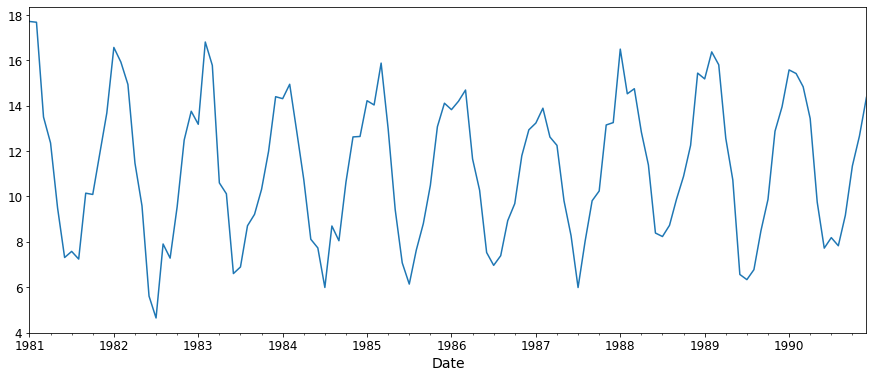

In [10]:
y.plot(figsize=(15, 6))
plt.show()

Some distinguishable patterns appear when we plot the data. The time-series has seasonality pattern, such as sales are always low at the beginning of the year and high at the end of the year. There is always an upward trend within any single year with a couple of low months in the mid of the year.

We can also visualize our data using a method called time-series decomposition that allows us to decompose our time series into three distinct components: trend, seasonality, and noise.

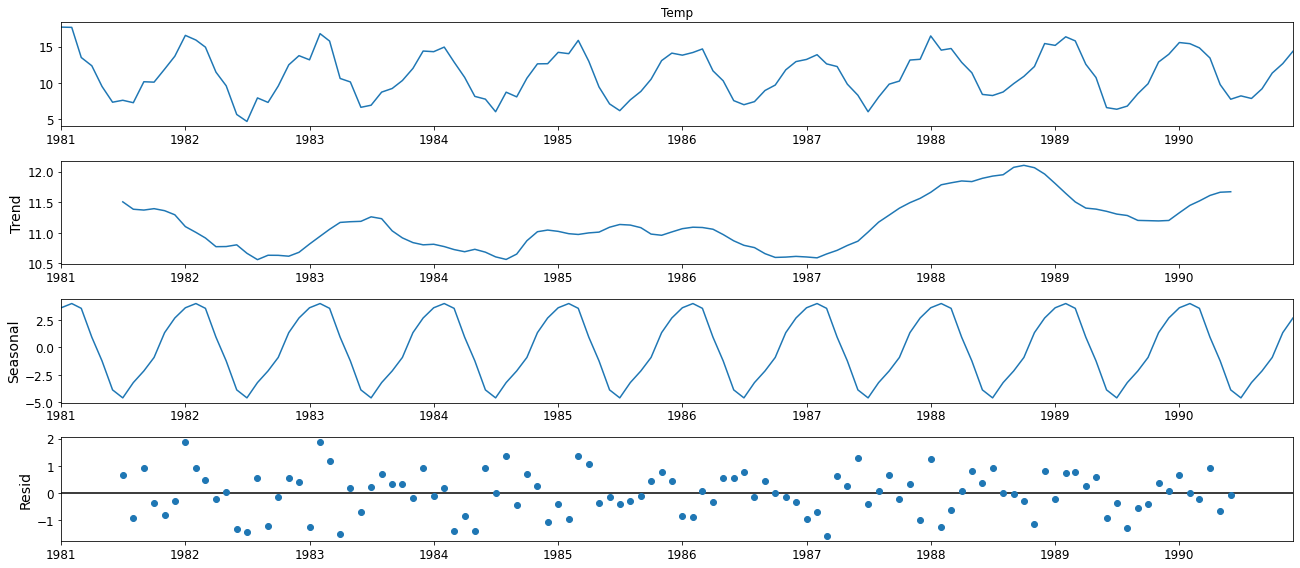

In [11]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()
plt.show()

# ARIMA: AutoRegressive Integrated Moving Average

#### ARIMA models are denoted with the notation ARIMA(p, d, q). These 3 parameters account for seasonality, trend, and noise in the data

In [12]:
# Define Range
p = d = q = range(0, 2)
# Cartesian product of input iterables.
pdq = list(itertools.product(p, d, q))

seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA\n===========================================\n')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

#### This step is parameter Selection for Temp: ARIMA Time Series Model. Our goal here is to use a “grid search” to find the optimal set of parameters that yields the best performance for our model.

## Optimal Parameters - with the smallest AIC score

In [13]:
mezahe = []
mezahe2 = []
aic_score = []

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
            mezahe.append(param)
            mezahe2.append(param_seasonal)
            aic_score.append(results.aic)
        except:
            continue

Examples of parameter combinations for Seasonal ARIMA

SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)
ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:922.3210617030475
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:722.9244540579089
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:362.6359128712689
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:269.34072425126453
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:367.4161911440841
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:321.34908417240905
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:295.80242894457945
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:275.38649770096583
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:774.7283182303579
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:611.949931238296
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:359.1289668445145
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:259.4981124416852
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:367.81784937161353
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:309.4232541171827
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 

In [14]:
df_tmp = pd.DataFrame({'m1':mezahe, 'm2':mezahe2, 'aic':aic_score})
df_tmp

,m1,m2,aic
0,"(0, 0, 0)","(0, 0, 0, 12)",922.321062
1,"(0, 0, 0)","(0, 0, 1, 12)",722.924454
2,"(0, 0, 0)","(0, 1, 0, 12)",362.635913
3,"(0, 0, 0)","(0, 1, 1, 12)",269.340724
4,"(0, 0, 0)","(1, 0, 0, 12)",367.416191
...,...,...,...
59,"(1, 1, 1)","(0, 1, 1, 12)",259.688451
60,"(1, 1, 1)","(1, 0, 0, 12)",359.189683
61,"(1, 1, 1)","(1, 0, 1, 12)",313.006634
62,"(1, 1, 1)","(1, 1, 0, 12)",288.347384


In [15]:
min_aic_index = df_tmp.index[df_tmp['aic'] == df_tmp['aic'].min()].tolist()
print("The Min. AIC is", df_tmp['aic'].min(), "and located in the", min_aic_index, "index")
print(df_tmp["m1"][min_aic_index])
print(df_tmp["m2"][min_aic_index])

The Min. AIC is 259.1981696110171 and located in the [43] index
43    (1, 0, 1)
Name: m1, dtype: object
43    (0, 1, 1, 12)
Name: m2, dtype: object


# Fitting the ARIMA Model

#### I have selected the smallest AIC params: ARIMA(1, 0, 1)x(0, 1, 1, 12)12 - AIC:259.19

In [16]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 0, 1), # Change according to the selected params
                                seasonal_order=(0, 1, 1, 12), # Change according to the selected params
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5701      0.209      2.723      0.006       0.160       0.980
ma.L1         -0.3072      0.249     -1.236      0.217      -0.795       0.180
ma.S.L12      -0.8090      0.137     -5.884      0.000      -1.078      -0.540
sigma2         0.7905      0.156      5.059      0.000       0.484       1.097


# Investigate any unusual behavior

It is close to but not perfect at all, however, our model diagnostics suggests that the model residuals are near normally distributed.

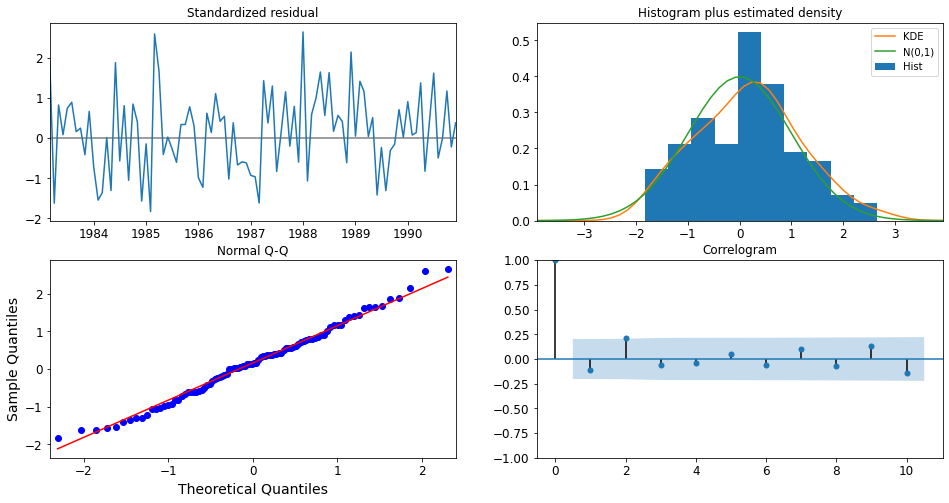

In [17]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

# Validating forecasts

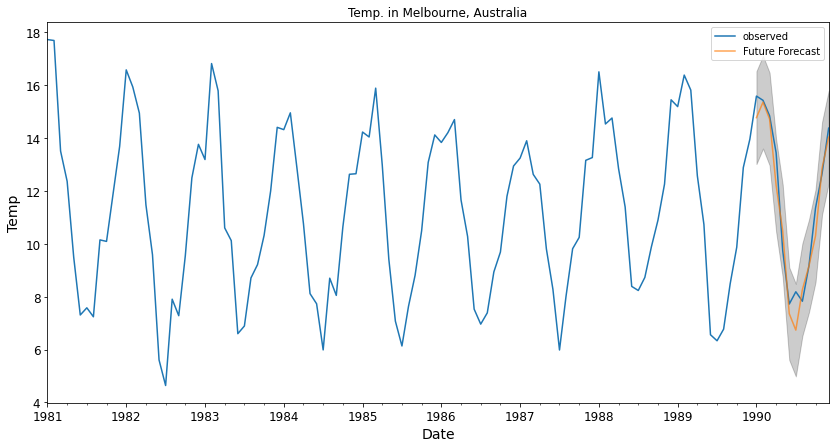

In [18]:
pred = results.get_prediction(start=pd.to_datetime('1990-01-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = y['1981':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='Future Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Temp')
plt.legend()
plt.title('Temp. in Melbourne, Australia')
plt.show()

The line plot is showing the observed values compared to the rolling forecast predictions. Overall, our forecasts align with the true values very well, showing an downward trend starts from the beginning of the year and captured the seasonality toward the end of the year with min. pick at the middle of the year

In [19]:
# y_true vs. y_pred
y_forecasted = pred.predicted_mean
y_truth = y['1990-01-01':]

# MSE
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

# RMSE
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Mean Squared Error of our forecasts is 0.54
The Root Mean Squared Error of our forecasts is 0.73


#### The MSE is a measure of the quality of an estimator — it is always non-negative, and the smaller the MSE, the closer we are to finding the line of best fit.

#### RMSE tells us that our model was able to forecast the average daily furniture sales in the test set within 151.64 of the real sales.

# Producing and visualizing forecasts

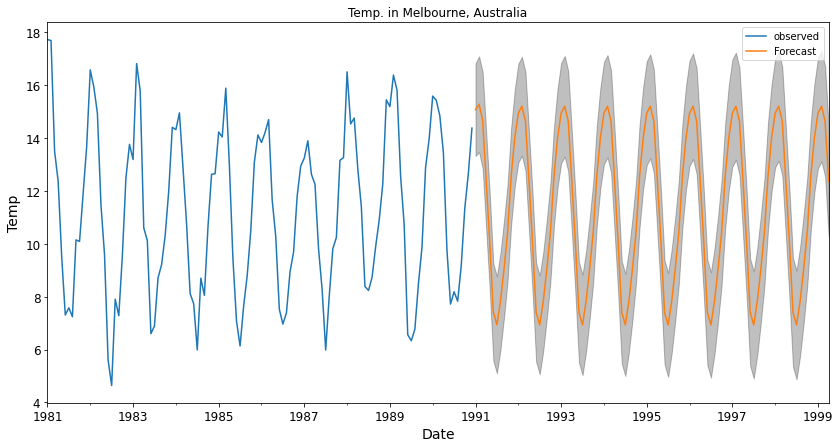

In [20]:
pred_uc = results.get_forecast(steps=100)
pred_ci = pred_uc.conf_int()
ax = y.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Temp')
plt.legend()
plt.title('Temp. in Melbourne, Australia')
plt.show()

# Time Series Modeling with Prophet

Released by Facebook in 2017, forecasting tool Prophet is designed for analyzing time-series that display patterns on different time scales such as yearly, weekly and daily. It also has advanced capabilities for modeling the effects of holidays on a time-series and implementing custom changepoints. Therefore, we are using Prophet to get a model up and running.

In [21]:
from fbprophet import Prophet

Importing plotly failed. Interactive plots will not work.


In [22]:
debt_copy_read = pd.read_csv("Minimum_Daily_Temperatures.csv", names = ["ds", "y"])
debt_copy_read = debt_copy_read.drop(0)
debt_copy_read

,ds,y
1,1981-01-01,20.7
2,1981-01-02,17.9
3,1981-01-03,18.8
4,1981-01-04,14.6
5,1981-01-05,15.8
...,...,...
3646,1990-12-27,14.0
3647,1990-12-28,13.6
3648,1990-12-29,13.5
3649,1990-12-30,15.7


In [23]:
# We fit the model by instantiating a new Prophet object. 
# Any settings to the forecasting procedure are passed into the constructor. 
# Then you call its fit method and pass in the historical dataframe.  

df_model = Prophet(interval_width=0.95)
df_model.fit(debt_copy_read)

# Predictions are then made on a dataframe with the date column which a prediction has to be made.
df_forecast = df_model.make_future_dataframe(periods=36, freq='MS')

# The predict method will assign each row in future a predicted value which it names yhat. 
# If you pass in historical dates, it will provide an in-sample fit. 
# The forecast object here is a new dataframe that includes a column yhat with the forecast, 
# as well as columns for components and uncertainty intervals.
df_forecast = df_model.predict(df_forecast)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Text(0.5, 1.0, 'Temp. in Melbourne, Australia')

<Figure size 1296x432 with 0 Axes>

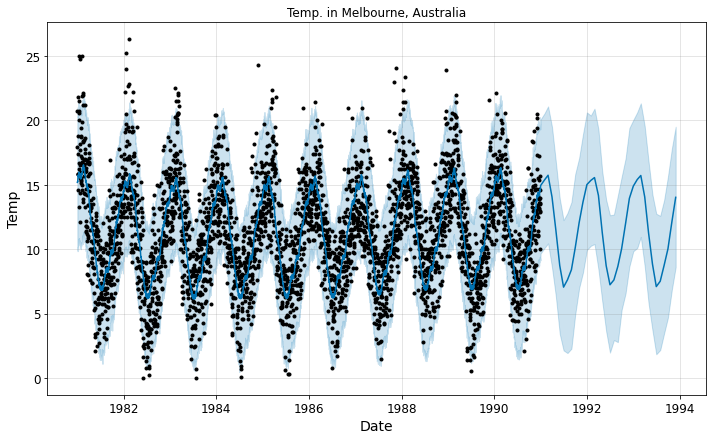

In [24]:
# Plotting model
plt.figure(figsize=(18, 6))
df_model.plot(df_forecast, xlabel = 'Date', ylabel = 'Temp')
plt.title('Temp. in Melbourne, Australia')

In [25]:
df_forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,1981-01-01,11.859172,9.944940,20.295305,11.859172,11.859172,3.328371,3.328371,3.328371,0.010954,0.010954,0.010954,3.317417,3.317417,3.317417,0.0,0.0,0.0,15.187543
1,1981-01-02,11.857325,10.125177,20.365280,11.857325,11.857325,3.375189,3.375189,3.375189,-0.019843,-0.019843,-0.019843,3.395032,3.395032,3.395032,0.0,0.0,0.0,15.232514
2,1981-01-03,11.855478,9.835671,21.025516,11.855478,11.855478,3.412035,3.412035,3.412035,-0.060133,-0.060133,-0.060133,3.472168,3.472168,3.472168,0.0,0.0,0.0,15.267513
3,1981-01-04,11.853631,10.169930,20.734806,11.853631,11.853631,3.394489,3.394489,3.394489,-0.153090,-0.153090,-0.153090,3.547579,3.547579,3.547579,0.0,0.0,0.0,15.248120
4,1981-01-05,11.851783,10.124976,20.241297,11.851783,11.851783,3.600337,3.600337,3.600337,-0.019707,-0.019707,-0.019707,3.620044,3.620044,3.620044,0.0,0.0,0.0,15.452120
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3681,1993-08-01,11.605300,2.162320,12.585692,10.958355,12.298532,-4.098130,-4.098130,-4.098130,-0.153090,-0.153090,-0.153090,-3.945040,-3.945040,-3.945040,0.0,0.0,0.0,7.507170
3682,1993-09-01,11.606047,3.465769,13.819416,10.929625,12.334811,-2.857629,-2.857629,-2.857629,0.163328,0.163328,0.163328,-3.020956,-3.020956,-3.020956,0.0,0.0,0.0,8.748418
3683,1993-10-01,11.606769,4.680694,15.641145,10.912083,12.369590,-1.583182,-1.583182,-1.583182,-0.019843,-0.019843,-0.019843,-1.563339,-1.563339,-1.563339,0.0,0.0,0.0,10.023587
3684,1993-11-01,11.607516,6.859831,17.820048,10.878990,12.400893,0.511497,0.511497,0.511497,-0.019707,-0.019707,-0.019707,0.531204,0.531204,0.531204,0.0,0.0,0.0,12.119013


# Trend and Forecast Visualization

### Trend

Text(0.5, 1.0, 'Temp Trend')

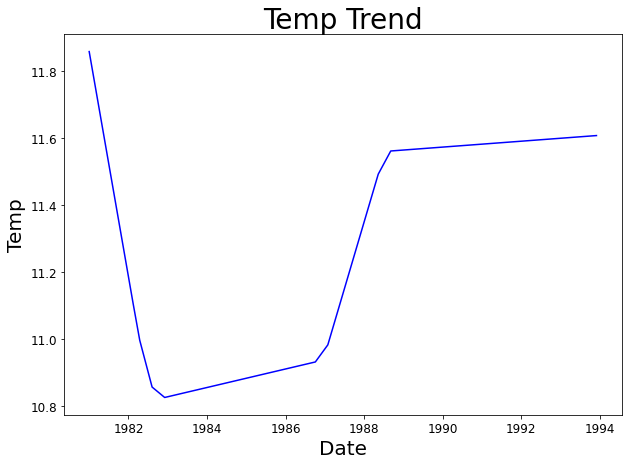

In [26]:
plt.figure(figsize=(10, 7))

# taking the furniture trend 
plt.plot(df_forecast['ds'], df_forecast['trend'], 'b-')
# taking the office products trend

# Plot

plt.xlabel('Date', size=20)
plt.ylabel('Temp', size=20)
plt.title('Temp Trend', size = 28)

### Forecast (y_hat)

Text(0.5, 1.0, 'Temp Estimate')

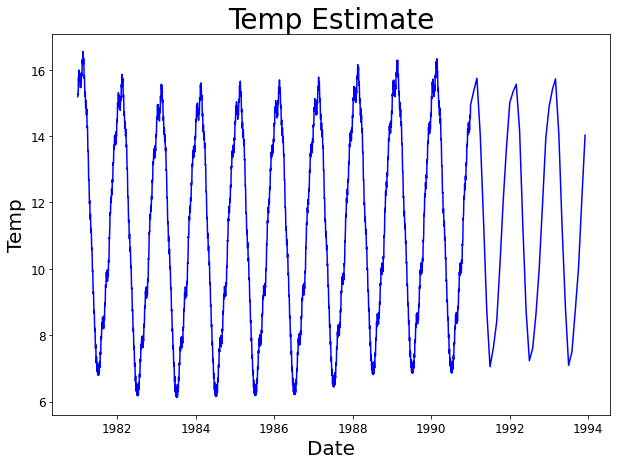

In [27]:
plt.figure(figsize=(10, 7))
plt.plot(df_forecast['ds'], df_forecast['yhat'], 'b-')
#plt.legend() 
plt.xlabel('Date', size=20) 
plt.ylabel('Temp', size=20)
plt.title('Temp Estimate', size=28)

# Trends and Patterns

### Now, we can use the Prophet Models to inspect different trends of these two categories in the data.

## Trend

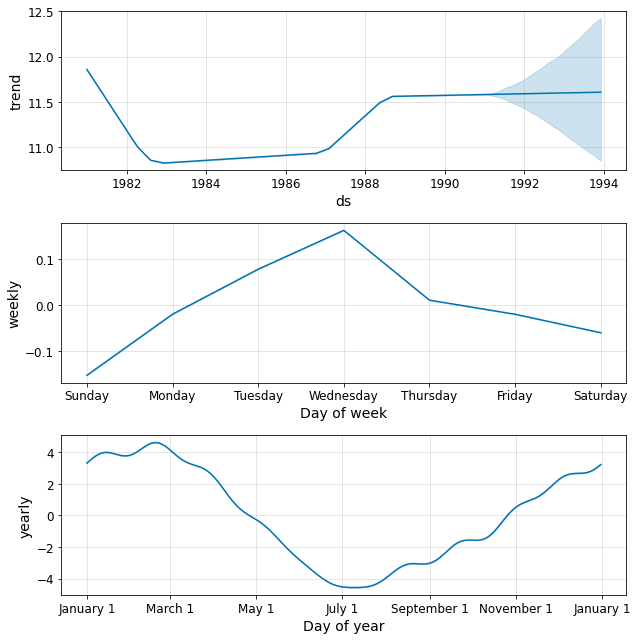

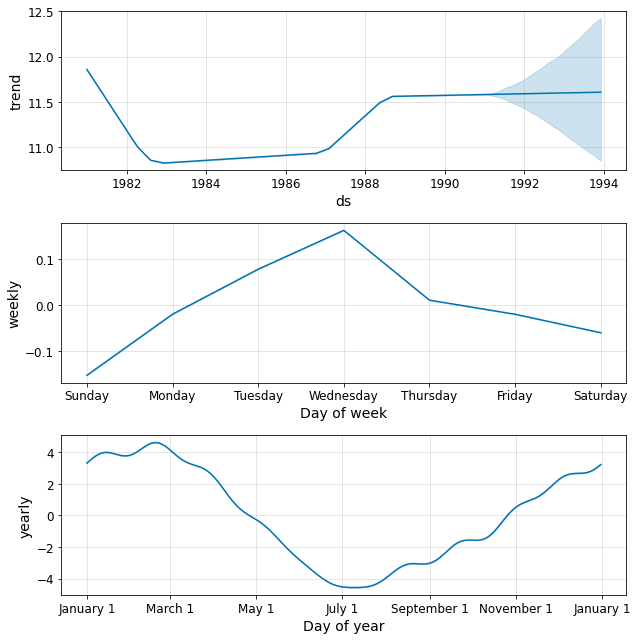

In [28]:
df_model.plot_components(df_forecast)